<a href="https://colab.research.google.com/github/Fxf28/project-capstone/blob/main/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import os
from pathlib import Path
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import math
import random
from tqdm import tqdm
import cv2
import shutil
import albumentations as A
import argparse
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Load Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fadliahmad","key":"3021d1423c9540cc1e916e9422e8016f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download joebeachcapital/realwaste
!unzip realwaste.zip

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
Archive:  realwaste.zip
  inflating: realwaste-main/README.md  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_108.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_109.jpg 

## Data Preparation

### List jumlah label dan gambar

In [ ]:
def list_image_folders(
    dataset_path: str = "path_datasetmu/",
    check_images: bool = True,
    min_images: int = 1
) -> List[Tuple[str, int]]:
    """
    Mencetak daftar folder dalam direktori dataset dengan informasi lengkap

    Parameters:
    - dataset_path: Path ke direktori dataset
    - check_images: Cek keberadaan file gambar dalam folder
    - min_images: Minimal jumlah gambar untuk ditampilkan

    Returns:
    - List of tuples (folder_name, image_count)
    """
    path = Path(dataset_path)

    # Validasi path secara detail
    if not path.exists():
        raise FileNotFoundError(f"Error: Direktori '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"Error: '{dataset_path}' bukan direktori")

    # Dapatkan daftar folder dengan Path
    folders = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for entry in path.iterdir():
        if entry.is_dir():
            if check_images:
                # Hitung file gambar dalam folder
                image_count = sum(
                    1 for f in entry.iterdir()
                    if f.is_file() and f.suffix.lower() in valid_extensions
                )
            else:
                image_count = -1  # Flag untuk pengecekan disabled

            if image_count >= min_images:
                folders.append((entry.name, image_count))

    # Urutkan berdasarkan nama folder
    folders.sort(key=lambda x: x[0].lower())

    # Tampilkan output formatting
    if not folders:
        print("Tidak ada folder dengan gambar yang ditemukan")
        return []

    print(f"Ditemukan {len(folders)} folder di '{path.absolute()}':")
    max_name_length = max(len(f[0]) for f in folders)
    count_total = 0
    for i, (folder, count) in enumerate(folders, start=1):
        count_info = f"({count} gambar)" if check_images else ""
        print(f"{i:2d}. {folder:{max_name_length}} {count_info}")
        count_total += count

    print(f"Jumlah Gambar {count_total}")
    return folders

In [ ]:
if __name__ == "__main__":
    folders_info = list_image_folders(
        dataset_path="realwaste-main/RealWaste",
        check_images=True,
        min_images=5
    )

    # Untuk mendapatkan daftar folder saja
    folder_names = [f[0] for f in folders_info]
    print("\nDaftar folder tersedia:", folder_names)

Ditemukan 9 folder di '/content/realwaste-main/RealWaste':
 1. Cardboard           (461 gambar)
 2. Food Organics       (411 gambar)
 3. Glass               (420 gambar)
 4. Metal               (790 gambar)
 5. Miscellaneous Trash (495 gambar)
 6. Paper               (500 gambar)
 7. Plastic             (921 gambar)
 8. Textile Trash       (318 gambar)
 9. Vegetation          (436 gambar)
Jumlah Gambar 4752

Daftar folder tersedia: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


### Cek Resolusi

In [ ]:
def get_resolution_summary(dataset_path: str = "path_datasetmu/"):
    """
    Menganalisis resolusi gambar dalam semua sub-direktori (kelas)
    dan menghasilkan ringkasan resolusi untuk seluruh dataset.

    Args:
        base_dir (str): Path ke direktori utama dataset.

    Returns:
        None: Mencetak ringkasan resolusi untuk seluruh dataset.
    """
    resolutions = {}
    total_images = 0
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                try:
                    with Image.open(filepath) as img:
                        width, height = img.size
                        resolution = (width, height)
                        resolutions[resolution] = resolutions.get(resolution, 0) + 1
                        total_images += 1
                except Exception as e:
                    print(f"Gagal membuka atau membaca gambar: {filepath} - {e}")

    unique_resolutions = set(resolutions.keys())
    print(f"Resolusi yang ditemukan: {unique_resolutions}")

    if len(unique_resolutions) == 1:
        for res in unique_resolutions:
            print(f"Semua gambar memiliki resolusi yang seragam: {res}")
    else:
        print("Resolusi tidak seragam.")

    print("\nJumlah gambar per resolusi:")
    for resolution, count in sorted(resolutions.items()):
        print(f"Resolusi {resolution}: {count} gambar")

In [ ]:
get_resolution_summary(dataset_path="realwaste-main/RealWaste")

Resolusi yang ditemukan: {(524, 524)}
Semua gambar memiliki resolusi yang seragam: (524, 524)

Jumlah gambar per resolusi:
Resolusi (524, 524): 4752 gambar


### Plot Sample

In [ ]:
def plot_category_samples(
    dataset_path: str = "path_datasetmu/",
    samples_per_category: int = 5,
    figsize: tuple = (14, 6),
    label_fontsize: int = 12,
    dpi: int = 100
) -> plt.Figure:
    """
    Memvisualisasikan sampel gambar dari setiap kategori dalam dataset

    Parameters:
    - dataset_path: Path ke direktori dataset
    - samples_per_category: Jumlah sampel gambar per kategori yang akan ditampilkan
    - figsize: Ukuran figure matplotlib (width, height)
    - label_fontsize: Ukuran font label kategori
    - dpi: Kualitas output gambar

    Returns:
    - matplotlib Figure object
    """
    path = Path(dataset_path)

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Cari kategori dengan gambar
    categories = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for category_dir in path.iterdir():
        if category_dir.is_dir():
            # Cek file gambar dengan glob
            image_files = list(category_dir.glob('*'))
            if any(f.suffix.lower() in valid_extensions for f in image_files):
                categories.append(category_dir.name)

    categories.sort()

    if not categories:
        print("Tidak ada kategori dengan gambar yang ditemukan")
        return None

    # Setup plot
    n_rows = len(categories)
    n_cols = samples_per_category
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0], figsize[1] + n_rows*0.5),  # Dynamic height
        dpi=dpi,
        gridspec_kw={'wspace':0.05, 'hspace':0.3}
    )

    # Handle single category case
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)

    # Hitung margin kiri berdasarkan panjang nama kategori terpanjang
    max_name_length = max(len(cat) for cat in categories)
    plt.subplots_adjust(left=0.2 + 0.01*max_name_length)

    # Plot gambar untuk setiap kategori
    for row_idx, category in enumerate(categories):
        category_path = path / category
        image_files = [
            f for f in category_path.iterdir()
            if f.is_file() and f.suffix.lower() in valid_extensions
        ]

        # Pilih sampel acak dengan jaminan unique
        selected_images = []
        if len(image_files) > 0:
            n_samples = min(samples_per_category, len(image_files))
            selected_indices = np.random.choice(len(image_files), n_samples, replace=False)
            selected_images = [image_files[i] for i in selected_indices]

        # Inisialisasi subplots
        for col_idx in range(n_cols):
            ax = axs[row_idx, col_idx]
            ax.axis('off')
            ax.set_facecolor('#f0f0f0')  # Warna background netral

            # Jika ada gambar yang valid
            if col_idx < len(selected_images):
                try:
                    img = Image.open(selected_images[col_idx])
                    ax.imshow(img)

                    # Tambah border
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('#808080')
                        spine.set_linewidth(0.5)

                except (UnidentifiedImageError, OSError) as e:
                    self._add_error_text(ax, f"Error: {e}")
            else:
                self._add_error_text(ax, "Tidak ada gambar")

        # Tambah label kategori
        axs[row_idx, 0].text(
            -0.3, 0.5,
            category,
            transform=axs[row_idx, 0].transAxes,
            fontsize=label_fontsize,
            fontweight='bold',
            va='center',
            ha='right',
            bbox=dict(
                boxstyle='round',
                facecolor='white',
                edgecolor='#404040',
                alpha=0.8,
                pad=0.3
            )
        )

    plt.show()
    return fig

def _add_error_text(ax, text: str):
    """Helper untuk menambahkan text error di subplot"""
    ax.text(
        0.5, 0.5,
        text,
        ha='center',
        va='center',
        color='red',
        fontsize=8,
        wrap=True
    )
    ax.set_facecolor('#fff0f0')  # Background merah muda untuk error

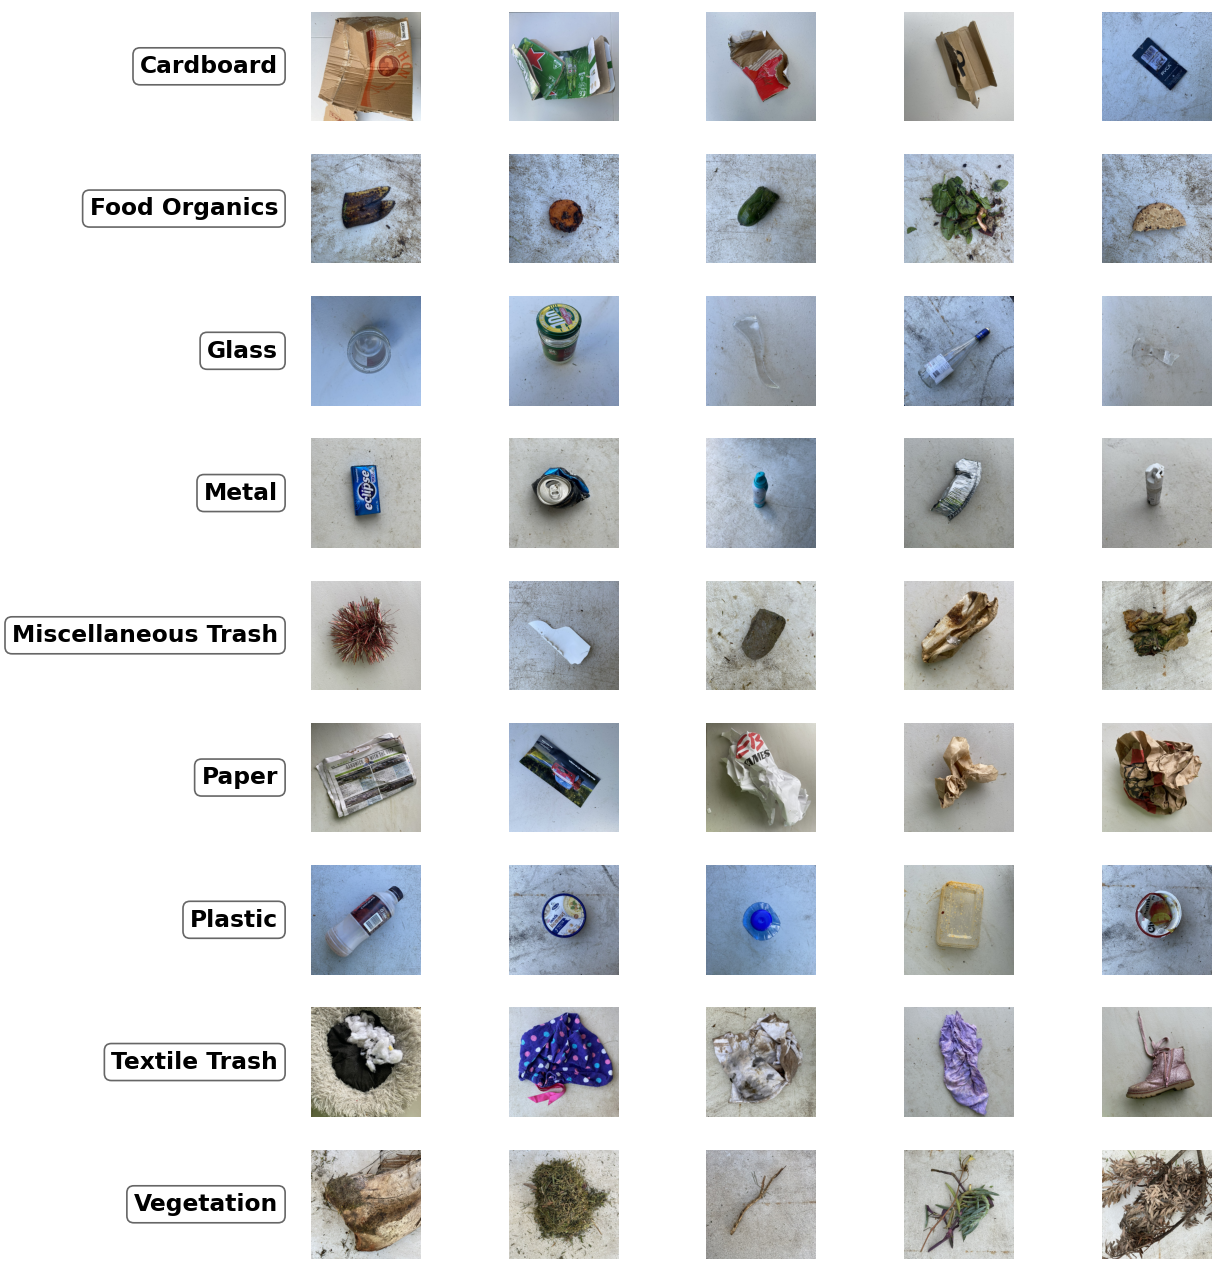

In [ ]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="realwaste-main/RealWaste",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

### Distribusi Gambar per Kelas

In [ ]:
def analyze_dataset_distribution(dataset_path: str = "path_datasetmy/") -> pd.DataFrame:
    """
    Menganalisis distribusi dataset dan membuat visualisasi

    Parameters:
    - dataset_path: Path ke direktori dataset

    Returns:
    - DataFrame berisi metadata dataset
    """
    path = Path(dataset_path)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Dataset path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Kumpulkan data dengan pathlib
    image_data = []
    for img_path in path.rglob('*'):
        if img_path.is_file() and img_path.suffix.lower() in valid_extensions:
            relative_path = img_path.relative_to(path)
            label = relative_path.parts[0]  # Ambil direktori level pertama
            image_data.append({
                "path": str(img_path),
                "file_name": img_path.name,
                "label": label,
                "extension": img_path.suffix.lower()
            })

    if not image_data:
        raise ValueError("Tidak ditemukan gambar valid dalam dataset")

    df = pd.DataFrame(image_data)

    # Plot distribusi
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(
        data=df,
        y='label',
        hue='label',
        legend=False,
        order=df['label'].value_counts().index,
        palette='viridis'
    )

    # Tambah annotasi
    total_images = len(df)
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f'{int(width)}\n({width/total_images:.1%})',
            (width + 0.1, p.get_y() + p.get_height()/2),
            ha='left',
            va='center'
        )

    plt.title(
        f"Distribusi Dataset - Total {len(df)} Gambar ({len(df['label'].unique())} Kategori)",
        fontsize=14,
        pad=20
    )
    plt.xlabel("Jumlah Gambar", labelpad=15)
    plt.ylabel("Kategori", labelpad=15)
    plt.xlim(0, df['label'].value_counts().max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df

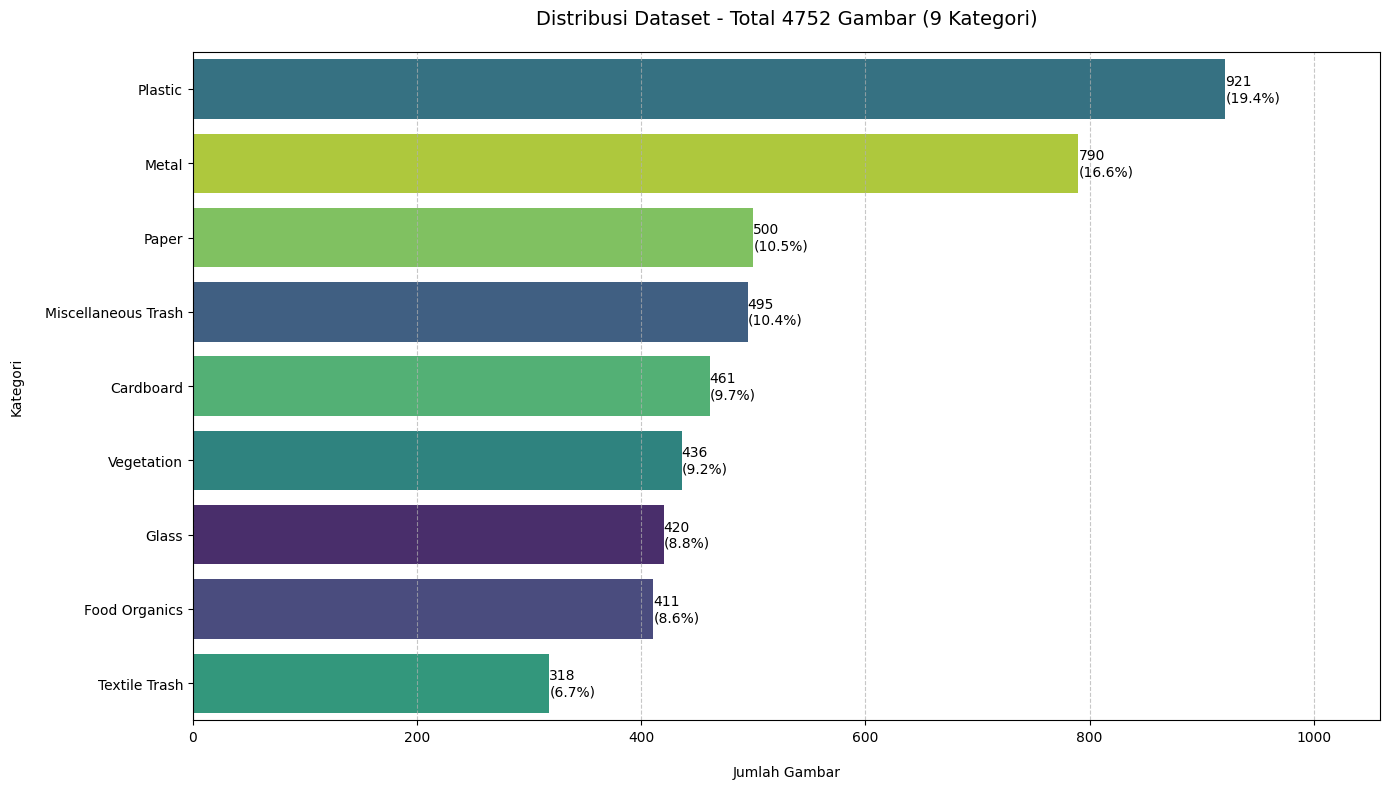


Contoh data:
                                                   path             file_name  \
3518       realwaste-main/RealWaste/Paper/Paper_317.jpg         Paper_317.jpg   
1821   realwaste-main/RealWaste/Plastic/Plastic_487.jpg       Plastic_487.jpg   
2903  realwaste-main/RealWaste/Textile Trash/Textile...  Textile Trash_37.jpg   
4033       realwaste-main/RealWaste/Metal/Metal_381.jpg         Metal_381.jpg   
660   realwaste-main/RealWaste/Food Organics/Food Or...  Food Organics_34.jpg   

              label extension  
3518          Paper      .jpg  
1821        Plastic      .jpg  
2903  Textile Trash      .jpg  
4033          Metal      .jpg  
660   Food Organics      .jpg  


In [ ]:
if __name__ == "__main__":
    dataset_df = analyze_dataset_distribution(
        dataset_path="realwaste-main/RealWaste/"
    )
    print("\nContoh data:")
    print(dataset_df.sample(5))

## Data Augmentation

Target Augmentasi 1000 gambar per kelas(total 9000)

In [ ]:
class Augmentor:
    def __init__(
        self,
        brightness_limit=0.2,
        contrast_limit=0.2,
        noise_limit=(10, 50),  # var_limit replaced with noise_limit
        flip_prob=0.5,
        rotate_limit=15,
        crop_scale=(0.9, 1.0)
    ):
        # define Albumentations augmentation pipeline
        self.pipeline = A.Compose([
            A.RandomBrightnessContrast(
                brightness_limit=brightness_limit,
                contrast_limit=contrast_limit,
                p=0.5
            ),
            # Use default parameters for GaussNoise; noise_limit maps to var_limit internally
            A.GaussNoise(p=0.3),
            A.HorizontalFlip(p=flip_prob),
            A.Rotate(limit=rotate_limit, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
            # updated RandomResizedCrop signature: use size param
            A.RandomResizedCrop(
                size=(524, 524),
                scale=crop_scale,
                ratio=(0.9, 1.1),
                p=0.4
            )
        ])

    def augment(self, img: np.ndarray) -> np.ndarray:
        # Apply the augmentation pipeline to an RGB uint8 image
        return self.pipeline(image=img)["image"]


def balance_dataset(
    input_dir: str,
    output_dir: str,
    target_count: int = 1000
):
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    for class_dir in input_path.iterdir():
        if not class_dir.is_dir() or class_dir.name.endswith('_aug'):
            continue

        class_name = class_dir.name
        output_class_dir = output_path / f"{class_name}_aug"
        if output_class_dir.exists():
            shutil.rmtree(output_class_dir)
        output_class_dir.mkdir(parents=True, exist_ok=True)

        original_images = list(class_dir.glob("*.*"))
        original_count = len(original_images)
        needed = max(0, target_count - original_count)

        if needed == 0:
            print(f"Kelas {class_name} sudah mencapai {original_count} gambar. Skip augmentasi.\n{'='*50}")
            continue

        print(f"\nKelas {class_name}: original={original_count}, needed={needed}")
        augmentor = Augmentor()

        per_img = math.ceil(needed / original_count)
        generated = 0

        with tqdm(total=needed, desc=f"Augmenting {class_name}") as pbar:
            for img_path in original_images:
                if generated >= needed:
                    break

                img = cv2.imread(str(img_path))  # BGR uint8
                if img is None:
                    print(f"Warning: tidak bisa membaca {img_path}")
                    continue
                # convert to RGB and resize
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (524, 524))

                for _ in range(per_img):
                    if generated >= needed:
                        break

                    aug_img = augmentor.augment(img)
                    # back to BGR for saving
                    aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                    out_name = output_class_dir / f"aug_{class_name}_{generated}{img_path.suffix}"
                    cv2.imwrite(str(out_name), aug_img_bgr)

                    generated += 1
                    pbar.update(1)

        print(f"Generated {generated}/{needed} images for class {class_name}\n{'='*50}")

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Balance dataset by augmenting images up to target count per class"
    )
    parser.add_argument(
        '--input_dir', '-i',
        type=str,
        default='realwaste-main/RealWaste/',
        help='Path ke folder dataset asli'
    )
    parser.add_argument(
        '--output_dir', '-o',
        type=str,
        default='realwaste-main/RealWaste/',
        help='Path untuk menyimpan hasil augmentasi'
    )
    parser.add_argument(
        '--target_count', '-t',
        type=int,
        default=500,
        help='Jumlah gambar per kelas setelah augmentasi'
    )
    # ignore default Jupyter args
    args, _ = parser.parse_known_args()

    balance_dataset(
        input_dir=args.input_dir,
        output_dir=args.output_dir,
        target_count=args.target_count
    )


Kelas Glass: original=420, needed=80


Augmenting Glass: 100%|██████████| 80/80 [00:00<00:00, 92.19it/s] 


Generated 80/80 images for class Glass

Kelas Food Organics: original=411, needed=89


Augmenting Food Organics: 100%|██████████| 89/89 [00:00<00:00, 92.23it/s]


Generated 89/89 images for class Food Organics

Kelas Miscellaneous Trash: original=495, needed=5


Augmenting Miscellaneous Trash: 100%|██████████| 5/5 [00:00<00:00, 81.63it/s]


Generated 5/5 images for class Miscellaneous Trash
Kelas Plastic sudah mencapai 921 gambar. Skip augmentasi.

Kelas Vegetation: original=436, needed=64


Augmenting Vegetation: 100%|██████████| 64/64 [00:00<00:00, 87.18it/s]


Generated 64/64 images for class Vegetation

Kelas Textile Trash: original=318, needed=182


Augmenting Textile Trash: 100%|██████████| 182/182 [00:01<00:00, 99.02it/s]


Generated 182/182 images for class Textile Trash

Kelas Cardboard: original=461, needed=39


Augmenting Cardboard: 100%|██████████| 39/39 [00:00<00:00, 102.29it/s]

Generated 39/39 images for class Cardboard
Kelas Paper sudah mencapai 500 gambar. Skip augmentasi.
Kelas Metal sudah mencapai 790 gambar. Skip augmentasi.


### Validasi Augmentasi

In [ ]:
if __name__ == "__main__":
    folders_info = list_image_folders(
        dataset_path="realwaste-main/RealWaste",
        check_images=True,
        min_images=5
    )

    # Untuk mendapatkan daftar folder saja
    folder_names = [f[0] for f in folders_info]
    print("\nDaftar folder tersedia:", folder_names)

Ditemukan 15 folder di '/content/realwaste-main/RealWaste':
 1. Cardboard               (461 gambar)
 2. Cardboard_aug           (39 gambar)
 3. Food Organics           (411 gambar)
 4. Food Organics_aug       (89 gambar)
 5. Glass                   (420 gambar)
 6. Glass_aug               (80 gambar)
 7. Metal                   (790 gambar)
 8. Miscellaneous Trash     (495 gambar)
 9. Miscellaneous Trash_aug (5 gambar)
10. Paper                   (500 gambar)
11. Plastic                 (921 gambar)
12. Textile Trash           (318 gambar)
13. Textile Trash_aug       (182 gambar)
14. Vegetation              (436 gambar)
15. Vegetation_aug          (64 gambar)
Jumlah Gambar 5211

Daftar folder tersedia: ['Cardboard', 'Cardboard_aug', 'Food Organics', 'Food Organics_aug', 'Glass', 'Glass_aug', 'Metal', 'Miscellaneous Trash', 'Miscellaneous Trash_aug', 'Paper', 'Plastic', 'Textile Trash', 'Textile Trash_aug', 'Vegetation', 'Vegetation_aug']


In [ ]:
get_resolution_summary(dataset_path="realwaste-main/RealWaste")

Resolusi yang ditemukan: {(524, 524)}
Semua gambar memiliki resolusi yang seragam: (524, 524)

Jumlah gambar per resolusi:
Resolusi (524, 524): 5211 gambar


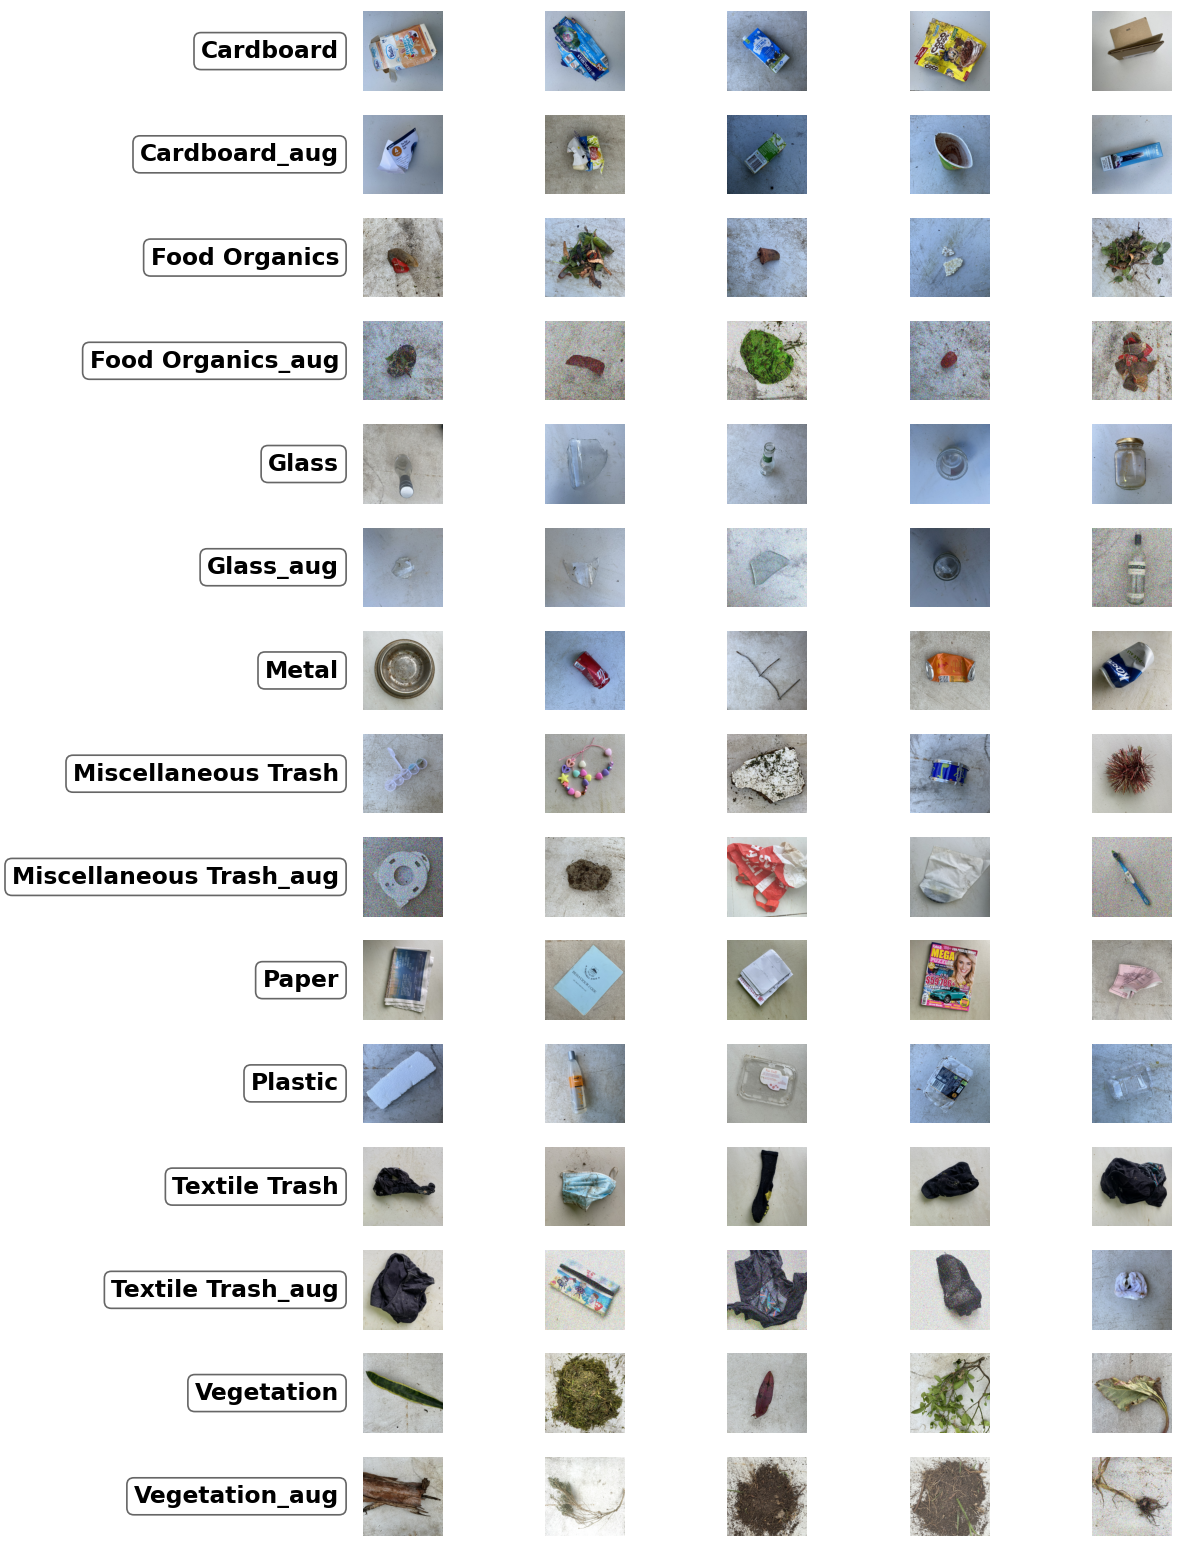

In [ ]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="realwaste-main/RealWaste",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

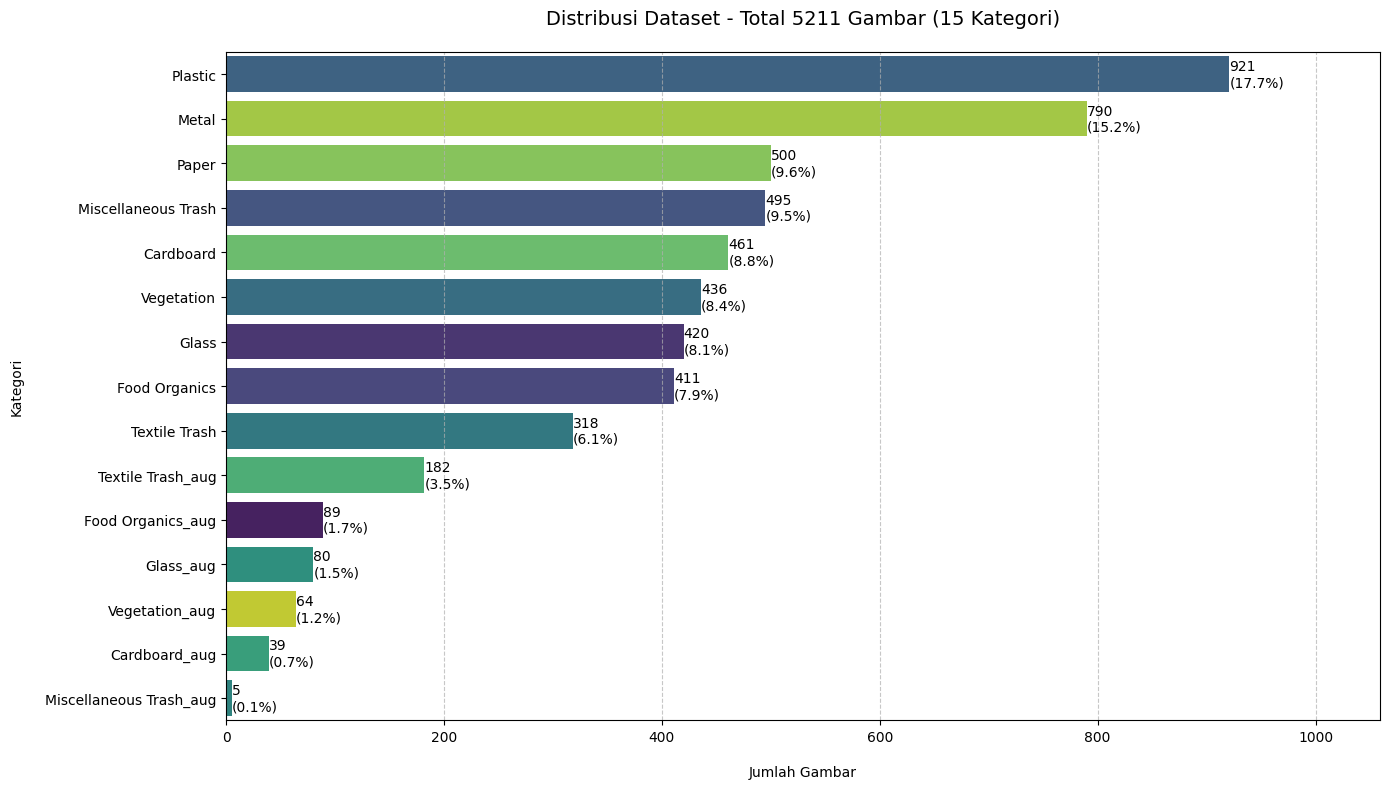


Contoh data:
                                                   path  \
1261  realwaste-main/RealWaste/Miscellaneous Trash/M...   
299         realwaste-main/RealWaste/Glass/Glass_50.jpg   
29    realwaste-main/RealWaste/Food Organics_aug/aug...   
1158  realwaste-main/RealWaste/Miscellaneous Trash/M...   
3201  realwaste-main/RealWaste/Cardboard_aug/aug_Car...   

                        file_name                label extension  
1261  Miscellaneous Trash_120.jpg  Miscellaneous Trash      .jpg  
299                  Glass_50.jpg                Glass      .jpg  
29       aug_Food Organics_30.jpg    Food Organics_aug      .jpg  
1158  Miscellaneous Trash_240.jpg  Miscellaneous Trash      .jpg  
3201         aug_Cardboard_24.jpg        Cardboard_aug      .jpg  


In [ ]:
if __name__ == "__main__":
    dataset_df = analyze_dataset_distribution(
        dataset_path="realwaste-main/RealWaste/"
    )
    print("\nContoh data:")
    print(dataset_df.sample(5))

## Data Preparation

Data splitting train val test

In [ ]:
def create_split_dataframe(
    input_dir="realwaste-main/RealWaste/",
    output_dir="dataset_split",
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
):
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    # Buat direktori utama
    splits = ['train', 'val', 'test']
    for split in splits:
        (output_path/split).mkdir(parents=True, exist_ok=True)

    dataframe = []

    for class_dir in input_path.iterdir():
        if not class_dir.is_dir():
            continue

        class_name = class_dir.name.replace("_aug", "")
        print(f"\nProcessing class: {class_name}")

        # Baca semua gambar original dan augmented
        original_images = list((input_path/class_name).glob("*.*"))
        augmented_images = list((input_path/f"{class_name}_aug").glob("*.*")) if (input_path/f"{class_name}_aug").exists() else []

        # Split original images
        random.shuffle(original_images)
        total_original = len(original_images)

        # Hitung jumlah split
        val_size = math.floor(total_original * val_ratio)
        test_size = math.floor(total_original * test_ratio)
        train_size = total_original - val_size - test_size

        # Split dataset
        train_images = original_images[:train_size]
        val_images = original_images[train_size:train_size+val_size]
        test_images = original_images[train_size+val_size:]

        # Proses semua gambar
        print("Memproses split dataset...")

        # Salin original images ke split folders
        for split, images in zip(splits, [train_images, val_images, test_images]):
            split_dir = output_path/split/class_name
            split_dir.mkdir(exist_ok=True)

            for img_path in tqdm(images, desc=f"Original {split}"):
                shutil.copy(img_path, split_dir/img_path.name)
                dataframe.append({
                    'filepath': str(split_dir/img_path.name),
                    'label': class_name,
                    'split': split,
                    'augmented': False
                })

        # Salin augmented images ke train folder
        if augmented_images:
            train_dir = output_path/'train'/class_name
            train_dir.mkdir(exist_ok=True)

            for img_path in tqdm(augmented_images, desc="Augmented"):
                shutil.copy(img_path, train_dir/img_path.name)
                dataframe.append({
                    'filepath': str(train_dir/img_path.name),
                    'label': class_name,
                    'split': 'train',
                    'augmented': True
                })

    # Simpan dataframe
    df = pd.DataFrame(dataframe)
    df.to_csv(output_path/'dataset_info.csv', index=False)
    print("\nDataframe berhasil disimpan di:", output_path/'dataset_info.csv')
    return df

In [ ]:
if __name__ == "__main__":
    create_split_dataframe()


Processing class: Food Organics
Memproses split dataset...


Augmented: 100%|██████████| 89/89 [00:00<00:00, 2421.84it/s]



Processing class: Glass
Memproses split dataset...


Augmented: 100%|██████████| 80/80 [00:00<00:00, 2923.98it/s]



Processing class: Food Organics
Memproses split dataset...


Augmented: 100%|██████████| 89/89 [00:00<00:00, 2175.80it/s]



Processing class: Miscellaneous Trash
Memproses split dataset...


Augmented: 100%|██████████| 5/5 [00:00<00:00, 2356.62it/s]



Processing class: Plastic
Memproses split dataset...


Original test: 100%|██████████| 92/92 [00:00<00:00, 1887.95it/s]



Processing class: Vegetation
Memproses split dataset...


Augmented: 100%|██████████| 64/64 [00:00<00:00, 1353.34it/s]



Processing class: Textile Trash
Memproses split dataset...


Augmented: 100%|██████████| 182/182 [00:00<00:00, 1539.80it/s]



Processing class: Paper
Memproses split dataset...


Original test: 100%|██████████| 50/50 [00:00<00:00, 1850.27it/s]



Processing class: Miscellaneous Trash
Memproses split dataset...


Augmented: 100%|██████████| 5/5 [00:00<00:00, 1936.43it/s]



Processing class: Glass
Memproses split dataset...


Augmented: 100%|██████████| 80/80 [00:00<00:00, 2155.72it/s]



Processing class: Cardboard
Memproses split dataset...


Augmented: 100%|██████████| 39/39 [00:00<00:00, 1826.75it/s]



Processing class: Plastic
Memproses split dataset...


Original test: 100%|██████████| 92/92 [00:00<00:00, 544.53it/s]



Processing class: Textile Trash
Memproses split dataset...


Augmented: 100%|██████████| 182/182 [00:00<00:00, 560.19it/s]



Processing class: Cardboard
Memproses split dataset...


Augmented: 100%|██████████| 39/39 [00:00<00:00, 2000.32it/s]



Processing class: Paper
Memproses split dataset...


Original test: 100%|██████████| 50/50 [00:00<00:00, 2831.54it/s]



Processing class: Metal
Memproses split dataset...


Original test: 100%|██████████| 79/79 [00:00<00:00, 3517.22it/s]



Processing class: Metal
Memproses split dataset...


Original test: 100%|██████████| 79/79 [00:00<00:00, 4314.23it/s]



Processing class: Vegetation
Memproses split dataset...


Augmented: 100%|██████████| 64/64 [00:00<00:00, 1071.64it/s]



Dataframe berhasil disimpan di: dataset_split/dataset_info.csv


### Image Data Generator

In [ ]:
# Path direktori
TRAIN_DIR = "dataset_split/train"
VAL_DIR = "dataset_split/val"
TEST_DIR = "dataset_split/test"

# Generator dengan penyesuaian
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=42  # Tambahkan seed untuk reproducibility
)

# Generator untuk validasi
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 5035 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Found 908 images belonging to 9 classes.


In [ ]:
for x, y in train_generator:
    print(f"Input shape: {x.shape}")
    print(f"Label shape: {y.shape}")
    break

Input shape: (32, 224, 224, 3)
Label shape: (32, 9)


In [ ]:
print("Train classes:", train_generator.class_indices)
print("Validation classes:", validation_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Train classes: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}
Validation classes: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}
Test classes: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


## Pemodelan

### Klasik CNN

In [ ]:
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

def build_model():
    model = Sequential(name="LightDigitCNN")

    # Blok Konvolusi 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))

    # Blok Konvolusi 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    # Blok Feature Extraction
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    # Opsional: 1x1 convolution untuk pencampuran channel tanpa menambah banyak parameter
    model.add(Conv2D(128, (1,1), activation='relu', padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Inisialisasi model
model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "LightDigitCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,993 (617.16 KB)

 Trainable params: 157,545 (615.41 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
optimizer = Adam(learning_rate=1e-3)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

In [ ]:
# Training model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 59s 254ms/step - accuracy: 0.3165 - loss: 2.1200 - precision: 0.4199 - recall: 0.1664 - val_accuracy: 0.1989 - val_loss: 2.5592 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 174ms/step - accuracy: 0.3887 - loss: 1.7943 - precision: 0.5080 - recall: 0.2077 - val_accuracy: 0.0933 - val_loss: 3.5413 - val_precision: 0.1304 - val_recall: 0.0767 - learning_rate: 0.0010
Epoch 3/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.4727 - loss: 1.5578 - precision: 0.5940 - recall: 0.2758 - val_accuracy: 0.1289 - val_loss: 3.1354 - val_precision: 0.1453 - val_recall: 0.0856 - learning_rate: 0.0010
Epoch 4/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.5177 - loss: 1.3987 - precision: 0.6663 - recall: 0.3388 - val_accuracy: 0.3378 - val_loss: 1.9842 - val_precision: 0.3881 - val_recall: 0.2756 - learning_rate: 0.0010
Epoch 5/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 

### Tranfer Learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze semua layer base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
history1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 51s 221ms/step - accuracy: 0.4580 - loss: 1.7007 - val_accuracy: 0.7922 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 2/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.7251 - loss: 0.8037 - val_accuracy: 0.8444 - val_loss: 0.5155 - learning_rate: 0.0010
Epoch 3/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.7707 - loss: 0.6900 - val_accuracy: 0.8756 - val_loss: 0.4087 - learning_rate: 0.0010
Epoch 4/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.7989 - loss: 0.5987 - val_accuracy: 0.9033 - val_loss: 0.3625 - learning_rate: 0.0010
Epoch 5/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.8164 - loss: 0.5507 - val_accuracy: 0.9100 - val_loss: 0.3146 - learning_rate: 0.0010
Unfreezing top 50 layers and recompiling...
Epoch 6/30


TypeError: 'NoneType' object is not callable

In [ ]:
num_unfreeze = int(len(base_model.layers) * 0.3)
for layer in base_model.layers[-num_unfreeze:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop_ft = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce_ft  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop_ft, lr_reduce_ft]
)

### Evaluasi

## Konversi Model

## Inferensi